In [3]:
!pip install xgboost lightgbm scikit-learn

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 882.6 kB/s eta 0:01:21
   ---------------------------------------- 0.8/72.0 MB 1.0 MB/s eta 0:01:08
    --------------------------------------- 1.3/72.0 MB 1.3 MB/s eta 0:00:55
    --------------------------------------- 1.6/72.0 MB 1.4 MB/s et

In [1]:


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature Selection
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel, VarianceThreshold
)

# Modèles de classification
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modèles optimisés mémoire
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Utilitaires
import gc
from datetime import datetime

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


print(f" Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Date: 2025-12-04 19:40:25


In [2]:
df = pd.read_csv('data/tracks_spectral_reduced.csv')

In [3]:
print(f"Shape initiale: {df.shape}")
print(f"\nValeurs manquantes par colonne:\n{df.isnull().sum()}")
print(f"\nDistribution de genre_top:\n{df['genre_top'].value_counts()}")

Shape initiale: (97288, 27)

Valeurs manquantes par colonne:
Unnamed: 0                   0
track_id                     0
album_title                  0
album_tracks                 0
artist_latitude              0
artist_longitude             0
artist_name                  0
duration                     0
genre_top                    0
genres                       0
genres_all                   0
title                        0
spectral_bandwidth_max_01    0
spectral_bandwidth_min_01    0
spectral_bandwidth_std_01    0
spectral_centroid_max_01     0
spectral_centroid_min_01     0
spectral_centroid_std_01     0
spectral_rolloff_max_01      0
spectral_rolloff_min_01      0
spectral_rolloff_std_01      0
artist_location_unknown      0
g4_pc1                       0
g5_pc1                       0
g6_pc1                       0
g6_pc2                       0
g6_pc3                       0
dtype: int64

Distribution de genre_top:
genre_top
38      23718
15      22756
12      20140
17       

In [4]:
columns_to_drop = ['genres', 'genres_all']
df = df.drop(columns=columns_to_drop)

In [5]:
cols_to_exclude = [
    'track_id', # identifiant arbitraire
    'album_title', 
    'artist_name', 
    'title',
    'album_tracks',
    'genre_top'  # La cible
]

In [12]:
# Sélectionner uniquement les features numériques
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in cols_to_exclude]


print(f"FEATURES SÉLECTIONNÉES ({len(numeric_features)} colonnes)")
print(f"{'='*60}")
print(numeric_features)

FEATURES SÉLECTIONNÉES (19 colonnes)
['Unnamed: 0', 'artist_latitude', 'artist_longitude', 'duration', 'spectral_bandwidth_max_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_std_01', 'spectral_centroid_max_01', 'spectral_centroid_min_01', 'spectral_centroid_std_01', 'spectral_rolloff_max_01', 'spectral_rolloff_min_01', 'spectral_rolloff_std_01', 'artist_location_unknown', 'g4_pc1', 'g5_pc1', 'g6_pc1', 'g6_pc2', 'g6_pc3']


In [7]:
X = df[numeric_features].copy()
y = df['genre_top'].copy()

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

In [29]:
distribution_pct = pd.Series(y).value_counts(normalize=True) * 100
print(" Distribution des classes (%):")
print(distribution_pct)

 Distribution des classes (%):
11    24.379163
7     23.390346
5     20.701423
8      7.512746
4      6.876490
10     4.501069
0      2.536798
6      2.156484
13     2.049585
2      1.948853
3      1.899515
1      1.423608
9      0.619809
12     0.004112
Name: proportion, dtype: float64


In [31]:
mapping_df = pd.DataFrame({
        'Label Original': le.classes_,
        'Code Encodé': range(len(le.classes_))
    })
print(mapping_df)

    Label Original  Code Encodé
0                2            0
1                3            1
2                4            2
3                5            3
4               10            4
5               12            5
6               13            6
7               15            7
8               17            8
9               20            9
10              21           10
11              38           11
12             763           12
13            1235           13


In [ ]:
distribution_pct = y['genre_top'].value_counts(normalize=True) * 100
print("Distribution des classes (%):")
print(distribution_pct)

In [14]:

# 4. SPLIT STRATIFIÉ TRAIN/VAL/TEST


print("\n" + "="*80)
print("SPLIT DES DONNÉES (STRATIFIÉ)")
print("="*80)

# Split train+val / test (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train+Val set: {X_trainval.shape[0]:,} exemples")
print(f"Test set:      {X_test.shape[0]:,} exemples")
print(f"\n   Proportion: {X_trainval.shape[0]/len(y)*100:.1f}% / {X_test.shape[0]/len(y)*100:.1f}%")

#STANDARDISATION 
print("\n Standardisation des features...")
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

print("   ✓ StandardScaler ajusté sur train+val")
print("   ✓ Transformation appliquée sur test")
print(f"\n   Moyenne des features (train): {X_trainval_scaled.mean():.6f}")
print(f"   Écart-type des features (train): {X_trainval_scaled.std():.6f}")

# Vérifier la distribution des classes
train_dist = pd.Series(y_trainval).value_counts(normalize=True).head(5)
test_dist = pd.Series(y_test).value_counts(normalize=True).head(5)

print("\n Distribution des 5 classes principales:")
print("   Train+Val:")
for cls, prop in train_dist.items():
    print(f"      Classe {cls}: {prop*100:.2f}%")
print("   Test:")
for cls, prop in test_dist.items():
    print(f"      Classe {cls}: {prop*100:.2f}%")

print("\n Split stratifié réussi - distributions similaires")


SPLIT DES DONNÉES (STRATIFIÉ)
Train+Val set: 77,830 exemples
Test set:      19,458 exemples

   Proportion: 80.0% / 20.0%

 Standardisation des features...
   ✓ StandardScaler ajusté sur train+val
   ✓ Transformation appliquée sur test

   Moyenne des features (train): 0.000000
   Écart-type des features (train): 1.000000

 Distribution des 5 classes principales:
   Train+Val:
      Classe 11: 24.38%
      Classe 7: 23.39%
      Classe 5: 20.70%
      Classe 8: 7.51%
      Classe 4: 6.88%
   Test:
      Classe 11: 24.38%
      Classe 7: 23.39%
      Classe 5: 20.70%
      Classe 8: 7.51%
      Classe 4: 6.88%

 Split stratifié réussi - distributions similaires


In [15]:

# 5. MODÈLES OPTIMISÉS POUR LA RAM



print("CONFIGURATION DES MODÈLES (OPTIMISÉS MÉMOIRE)")
print("="*80)

# Nombre de classes
n_classes = len(np.unique(y))
print(f"\n Nombre de classes: {n_classes}")

#MODÈLES 
models = {
    # Modèles linéaires (rapides, peu de RAM)
    'Logistic Regression': LogisticRegression(
        max_iter=500, 
        random_state=42, 
        n_jobs=-1,
        solver='saga',  # Plus efficace en mémoire
        C=0.1  # Régularisation pour éviter overfitting
    ),
    
    'Ridge Classifier': RidgeClassifier(
        alpha=1.0,
        random_state=42
    ),
    
    # LDA (efficace pour multi-classes)
    'LDA': LinearDiscriminantAnalysis(),
    
    # Naive Bayes (très rapide)
    'Naive Bayes': GaussianNB(),
    
    # Decision Tree (contrôle de la profondeur)
    'Decision Tree ': DecisionTreeClassifier(
        max_depth=15,  # Limiter la profondeur
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    ),
    
    # === RANDOM FOREST  ===
    'Random Forest ': RandomForestClassifier(
        n_estimators=100,  # Réduire le nombre d'arbres
        max_depth=15,      # Limiter la profondeur
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',  # Réduire features par split
        n_jobs=2,          # Limiter les jobs parallèles
        random_state=42,
        max_samples=0.7,   # Sous-échantillonner
        warm_start=False
    ),
    
    # Extra Trees (similaire mais plus rapide)
    'Extra Trees ': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        n_jobs=2,
        random_state=42
    ),
    
    # === XGBOOST OPTIMISÉ RAM ===
    'XGBoost ': XGBClassifier(
        n_estimators=100,
        max_depth=6,           # Profondeur modérée
        learning_rate=0.1,
        subsample=0.8,         # Sous-échantillonner
        colsample_bytree=0.8,  # Sous-échantillonner features
        random_state=42,
        n_jobs=2,              # Limiter parallélisme
        tree_method='hist',    # Méthode efficace en mémoire
        max_bin=256,           # Réduire bins
        eval_metric='mlogloss' if n_classes > 2 else 'logloss'
    ),
    
    # === LIGHTGBM  ===
    'LightGBM ': LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        num_leaves=31,         # Contrôler complexité
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=2,
        force_col_wise=True,   # Optimisation mémoire
        verbose=-1
    ),
    

    
    # KNN (limiter les voisins)
    'kNN (k=5)': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=2
    ),
}

print(f"\n{len(models)} modèles configurés")
print("\nListe des modèles:")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")



CONFIGURATION DES MODÈLES (OPTIMISÉS MÉMOIRE)

 Nombre de classes: 14

10 modèles configurés

Liste des modèles:
   1. Logistic Regression
   2. Ridge Classifier
   3. LDA
   4. Naive Bayes
   5. Decision Tree 
   6. Random Forest 
   7. Extra Trees 
   8. XGBoost 
   9. LightGBM 
   10. kNN (k=5)


ENTRAÎNEMENT ET VALIDATION CROISÉE

 Stratified K-Fold: 5 folds

 Entraînement en cours...

----------------------------------------------------------------------------------------------------

 Modèle: Logistic Regression
----------------------------------------------------------------------------------------------------
    Val Accuracy:   38.46% (±0.34%)
    Train Accuracy: 38.52% (±0.10%)
   ✓ Overfitting:    0.07%

 Modèle: Ridge Classifier
----------------------------------------------------------------------------------------------------
    Val Accuracy:   36.65% (±0.49%)
    Train Accuracy: 36.71% (±0.13%)
   ✓ Overfitting:    0.05%

 Modèle: LDA
----------------------------------------------------------------------------------------------------
    Val Accuracy:   35.92% (±0.53%)
    Train Accuracy: 36.01% (±0.18%)
   ✓ Overfitting:    0.10%

 Modèle: Naive Bayes
----------------------------------------------------------------------------------------------------
    Val Accur

,Model,Val Accuracy (%),Val Std (%),Train Accuracy (%),Train Std (%),Overfitting (%)
8,LightGBM,58.083001,1.017643,68.910125,0.882475,10.827123
7,XGBoost,55.193370,0.473562,62.260696,0.127473,7.067326
5,Random Forest,47.330078,0.545610,57.488436,0.129176,10.158358
9,kNN (k=5),43.656688,0.362925,61.115251,0.089718,17.458564
6,Extra Trees,42.649364,0.379073,45.765772,0.148793,3.116408
4,Decision Tree,41.866889,0.310392,55.095079,0.037108,13.228190
0,Logistic Regression,38.459463,0.338494,38.524669,0.099948,0.065206
1,Ridge Classifier,36.654246,0.493534,36.708531,0.125690,0.054285
2,LDA,35.916742,0.527046,36.012463,0.175158,0.095721
3,Naive Bayes,25.883335,0.601072,25.972311,0.277072,0.088976



✓ Résultats sauvegardés: cv_results.csv
✓ Graphique sauvegardé: model_comparison.png


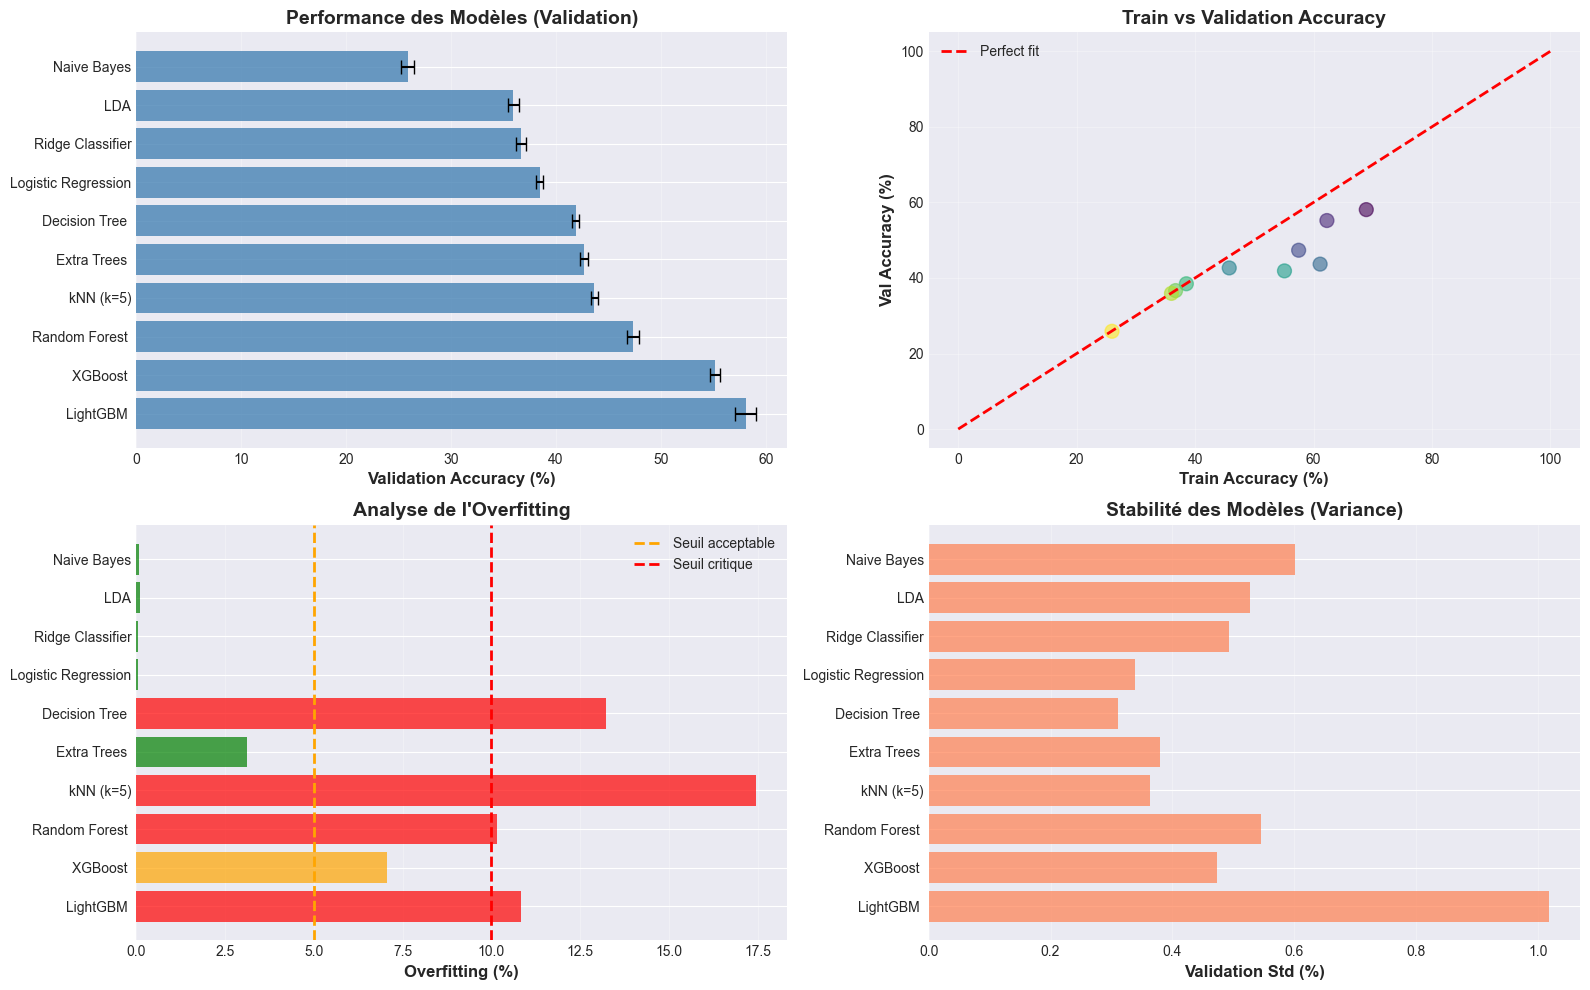


TOP 3 MODÈLES

 LightGBM 
   Val Accuracy:  58.08% ± 1.02%
   Train Accuracy: 68.91%
   Overfitting:    10.83%

 XGBoost 
   Val Accuracy:  55.19% ± 0.47%
   Train Accuracy: 62.26%
   Overfitting:    7.07%

 Random Forest 
   Val Accuracy:  47.33% ± 0.55%
   Train Accuracy: 57.49%
   Overfitting:    10.16%


OBJECTIF ATTEINT: Meilleure accuracy = 58.08% > 50%


In [ ]:

# 6. CROSS-VALIDATION ET ÉVALUATION


print("ENTRAÎNEMENT ET VALIDATION CROISÉE")

# Configuration CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"\n Stratified K-Fold: {cv.n_splits} folds")

# Résultats
results = []

print("\n Entraînement en cours...\n")
print("-" * 100)

for model_name, model in models.items():
    print(f"\n Modèle: {model_name}")
    print("-" * 100)
    
    try:
        # Décider si scaling nécessaire
        needs_scaling = model_name in [
            'Logistic Regression', 'Ridge Classifier', 'LDA', 
            'kNN (k=5)', 'SVM (Linear)'
        ]
        
        X_train_cv = X_trainval_scaled if needs_scaling else X_trainval.values
        
        # Cross-validation sur validation set
        val_scores = cross_val_score(
            model, X_train_cv, y_trainval, 
            cv=cv, scoring='accuracy', n_jobs=1  # n_jobs=1 pour éviter surcharge RAM
        )
        
        # Cross-validation sur train set pour détecter overfitting
        train_scores = []
        for train_idx, val_idx in cv.split(X_train_cv, y_trainval):
            X_fold_train = X_train_cv[train_idx]
            y_fold_train = y_trainval.iloc[train_idx] if hasattr(y_trainval, 'iloc') else y_trainval[train_idx]
            
            model.fit(X_fold_train, y_fold_train)
            train_score = model.score(X_fold_train, y_fold_train)
            train_scores.append(train_score)
        
        train_scores = np.array(train_scores)
        
        # Calculer les métriques
        val_mean = val_scores.mean() * 100
        val_std = val_scores.std() * 100
        train_mean = train_scores.mean() * 100
        train_std = train_scores.std() * 100
        overfitting = train_mean - val_mean
        
        results.append({
            'Model': model_name,
            'Val Accuracy (%)': val_mean,
            'Val Std (%)': val_std,
            'Train Accuracy (%)': train_mean,
            'Train Std (%)': train_std,
            'Overfitting (%)': overfitting
        })
        
        print(f"    Val Accuracy:   {val_mean:.2f}% (±{val_std:.2f}%)")
        print(f"    Train Accuracy: {train_mean:.2f}% (±{train_std:.2f}%)")
        print(f"   {'⚠️' if overfitting > 20 else '✓'} Overfitting:    {overfitting:.2f}%")
        
        # Libérer mémoire
        del val_scores, train_scores
        gc.collect()
        
    except Exception as e:
        print(f"    ERREUR: {str(e)}")
        results.append({
            'Model': model_name,
            'Val Accuracy (%)': 0,
            'Val Std (%)': 0,
            'Train Accuracy (%)': 0,
            'Train Std (%)': 0,
            'Overfitting (%)': 0
        })

# Créer DataFrame des résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Val Accuracy (%)', ascending=False)

print("\n\n" + "="*80)
print("RÉSULTATS DE LA VALIDATION CROISÉE")
print("="*80)
display(results_df)

# Sauvegarder les résultats
results_df.to_csv('data/cv_results.csv', index=False)
print("\n✓ Résultats sauvegardés: cv_results.csv")

# Visualisation
plt.figure(figsize=(16, 10))

# Graphique 1: Accuracy avec barres d'erreur
plt.subplot(2, 2, 1)
x_pos = np.arange(len(results_df))
plt.barh(x_pos, results_df['Val Accuracy (%)'], xerr=results_df['Val Std (%)'], 
         color='steelblue', capsize=5, alpha=0.8)
plt.yticks(x_pos, results_df['Model'])
plt.xlabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Performance des Modèles (Validation)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Graphique 2: Train vs Val
plt.subplot(2, 2, 2)
plt.scatter(results_df['Train Accuracy (%)'], results_df['Val Accuracy (%)'], 
           s=100, alpha=0.6, c=range(len(results_df)), cmap='viridis')
plt.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect fit')
plt.xlabel('Train Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylabel('Val Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 3: Overfitting
plt.subplot(2, 2, 3)
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' 
          for x in results_df['Overfitting (%)']]
plt.barh(x_pos, results_df['Overfitting (%)'], color=colors, alpha=0.7)
plt.yticks(x_pos, results_df['Model'])
plt.xlabel('Overfitting (%)', fontsize=12, fontweight='bold')
plt.title('Analyse de l\'Overfitting', fontsize=14, fontweight='bold')
plt.axvline(5, color='orange', linestyle='--', linewidth=2, label='Seuil acceptable')
plt.axvline(10, color='red', linestyle='--', linewidth=2, label='Seuil critique')
plt.legend()
plt.grid(axis='x', alpha=0.3)

# Graphique 4: Stabilité (Std)
plt.subplot(2, 2, 4)
plt.barh(x_pos, results_df['Val Std (%)'], color='coral', alpha=0.7)
plt.yticks(x_pos, results_df['Model'])
plt.xlabel('Validation Std (%)', fontsize=12, fontweight='bold')
plt.title('Stabilité des Modèles (Variance)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: model_comparison.png")
plt.show()

# Résumé
print("\n" + "="*80)
print("TOP 3 MODÈLES")
print("="*80)

for idx, row in results_df.head(3).iterrows():
    print(f"\n {row['Model']}")
    print(f"   Val Accuracy:  {row['Val Accuracy (%)']:.2f}% ± {row['Val Std (%)']:.2f}%")
    print(f"   Train Accuracy: {row['Train Accuracy (%)']:.2f}%")
    print(f"   Overfitting:    {row['Overfitting (%)']:.2f}%")

# Vérifier si accuracy > 50%
best_accuracy = results_df['Val Accuracy (%)'].max()
if best_accuracy > 50:
    print(f"\n\nOBJECTIF ATTEINT: Meilleure accuracy = {best_accuracy:.2f}% > 50%")
else:
    print(f"\n\n OBJECTIF NON ATTEINT: Meilleure accuracy = {best_accuracy:.2f}% < 50%")
    print("   → Essayer: plus de feature engineering, hyperparameter tuning, ou ensemble methods")

In [ ]:

# 7. HYPERPARAMETER TUNING 


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

best_accuracy = results_df['Val Accuracy (%)'].max()
a=8
if a>0:
    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING - Amélioration de l'Accuracy")
    print("="*80)
    
    # Sélectionner le meilleur modèle pour tuning
    top_models = results_df.head(1)['Model'].tolist()
    
    tuning_results = []
    
    for model_name in top_models:
        print(f"\n🔧 Tuning: {model_name}")
        print("-" * 80)
        
        # Définir les grilles de paramètres selon le modèle
        if 'Random Forest' in model_name or 'Extra Trees' in model_name:
            param_dist = {
                'n_estimators': randint(100, 300),
                'max_depth': [10, 15, 20, 25, None],
                'min_samples_split': randint(10, 50),
                'min_samples_leaf': randint(5, 20),
                'max_features': ['sqrt', 'log2', 0.5, 0.7]
            }
            base_model = RandomForestClassifier(random_state=42, n_jobs=2)
            
        elif 'XGBoost' in model_name:
            param_dist = {
                'n_estimators': randint(100, 300),
                'max_depth': randint(4, 10),
                'learning_rate': uniform(0.01, 0.2),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'gamma': uniform(0, 0.5)
            }
            base_model = XGBClassifier(
                random_state=42, n_jobs=2, tree_method='hist',
                eval_metric='mlogloss' if n_classes > 2 else 'logloss'
            )
            
        elif 'LightGBM' in model_name:
            param_dist = {
                'n_estimators': randint(100, 300),
                'max_depth': randint(5, 15),
                'learning_rate': uniform(0.01, 0.2),
                'num_leaves': randint(20, 50),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            }
            base_model = LGBMClassifier(
                random_state=42, n_jobs=2, verbose=-1, force_col_wise=True
            )
            
        elif 'Gradient Boosting' in model_name:
            param_dist = {
                'n_estimators': randint(100, 300),
                'max_depth': randint(3, 8),
                'learning_rate': uniform(0.01, 0.2),
                'subsample': uniform(0.6, 0.4),
                'min_samples_split': randint(10, 50),
                'min_samples_leaf': randint(5, 20)
            }
            base_model = GradientBoostingClassifier(random_state=42)
            
        else:
            print("    Pas de grille de paramètres définie, passage au suivant")
            continue
        
        # Randomized Search
        needs_scaling = model_name in ['Logistic Regression', 'Ridge Classifier', 'LDA', 'kNN (k=5)']
        X_train_cv = X_trainval_scaled if needs_scaling else X_trainval.values
        
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_dist,
            n_iter=20,  # Nombre d'itérations
            cv=3,       # 3 folds pour aller plus vite
            scoring='accuracy',
            n_jobs=1,   # Éviter surcharge RAM
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train_cv, y_trainval)
        
        # Résultats
        best_score = random_search.best_score_ * 100
        original_score = results_df[results_df['Model'] == model_name]['Val Accuracy (%)'].values[0]
        improvement = best_score - original_score
        
        print(f"\n    Meilleurs paramètres trouvés:")
        for param, value in random_search.best_params_.items():
            print(f"      {param}: {value}")
        print(f"\n    Accuracy originale:  {original_score:.2f}%")
        print(f"    Accuracy optimisée:  {best_score:.2f}%")
        print(f"   {'' if improvement > 0 else ''} Amélioration:       {improvement:+.2f}%")
        
        tuning_results.append({
            'Model': model_name + ' (tuned)',
            'Val Accuracy (%)': best_score,
            'Original Accuracy (%)': original_score,
            'Improvement (%)': improvement,
            'Best Params': random_search.best_params_
        })
        
        # Libérer mémoire
        del random_search
        gc.collect()
    
    # Afficher résumé tuning
    if tuning_results:
        tuning_df = pd.DataFrame(tuning_results)
        print("\n" + "="*80)
        print("RÉSULTATS DU TUNING")
        print("="*80)
        display(tuning_df[['Model', 'Original Accuracy (%)', 'Val Accuracy (%)', 'Improvement (%)']])
        
        print("\n✓ Résultats du tuning sauvegardés: tuning_results.csv")
        
        # Mettre à jour results_df avec les modèles tunés
        for result in tuning_results:
            results_df = pd.concat([
                results_df,
                pd.DataFrame([{
                    'Model': result['Model'],
                    'Val Accuracy (%)': result['Val Accuracy (%)'],
                    'Val Std (%)': 0,
                    'Train Accuracy (%)': 0,
                    'Train Std (%)': 0,
                    'Overfitting (%)': 0
                }])
            ], ignore_index=True)
        
        results_df = results_df.sort_values('Val Accuracy (%)', ascending=False)

else:
    print("\n✅ Accuracy > 50%, pas besoin de tuning supplémentaire")


HYPERPARAMETER TUNING - Amélioration de l'Accuracy

🔧 Tuning: LightGBM 
--------------------------------------------------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits

    Meilleurs paramètres trouvés:
      colsample_bytree: 0.8493192507310232
      learning_rate: 0.07617960497052984
      max_depth: 11
      n_estimators: 250
      num_leaves: 49
      subsample: 0.7300733288106989

    Accuracy originale:  58.08%
    Accuracy optimisée:  62.49%
    Amélioration:       +4.41%

RÉSULTATS DU TUNING


,Model,Original Accuracy (%),Val Accuracy (%),Improvement (%)
0,LightGBM (tuned),58.083001,62.49261,4.409609



✓ Résultats du tuning sauvegardés: tuning_results.csv


ÉVALUATION FINALE - LIGHTGBM (TUNED)

 Paramètres LightGBM optimisés :
   colsample_bytree: 0.8493192507310232
   learning_rate: 0.07617960497052984
   max_depth: 11
   n_estimators: 250
   num_leaves: 49
   subsample: 0.7300733288106989

 Réentraînement du LightGBM (tuned) sur train+val...
PERFORMANCE SUR LE TEST SET  - LIGHTGBM (TUNED)

 Test Accuracy: 65.44%
 Validation Accuracy du tuning: 62.49%
 Différence: 2.95%

--------------------------------------------------------------------------------
CLASSIFICATION REPORT (Top 10 classes):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

          11       0.66      0.76      0.71      4744
           7       0.63      0.75      0.68      4551
           5       0.65      0.70      0.67      4028
           8       0.70      0.52      0.60      1462
           4       0.79      0.44      0.56      1338
          10       0.74      0.54      0.63       

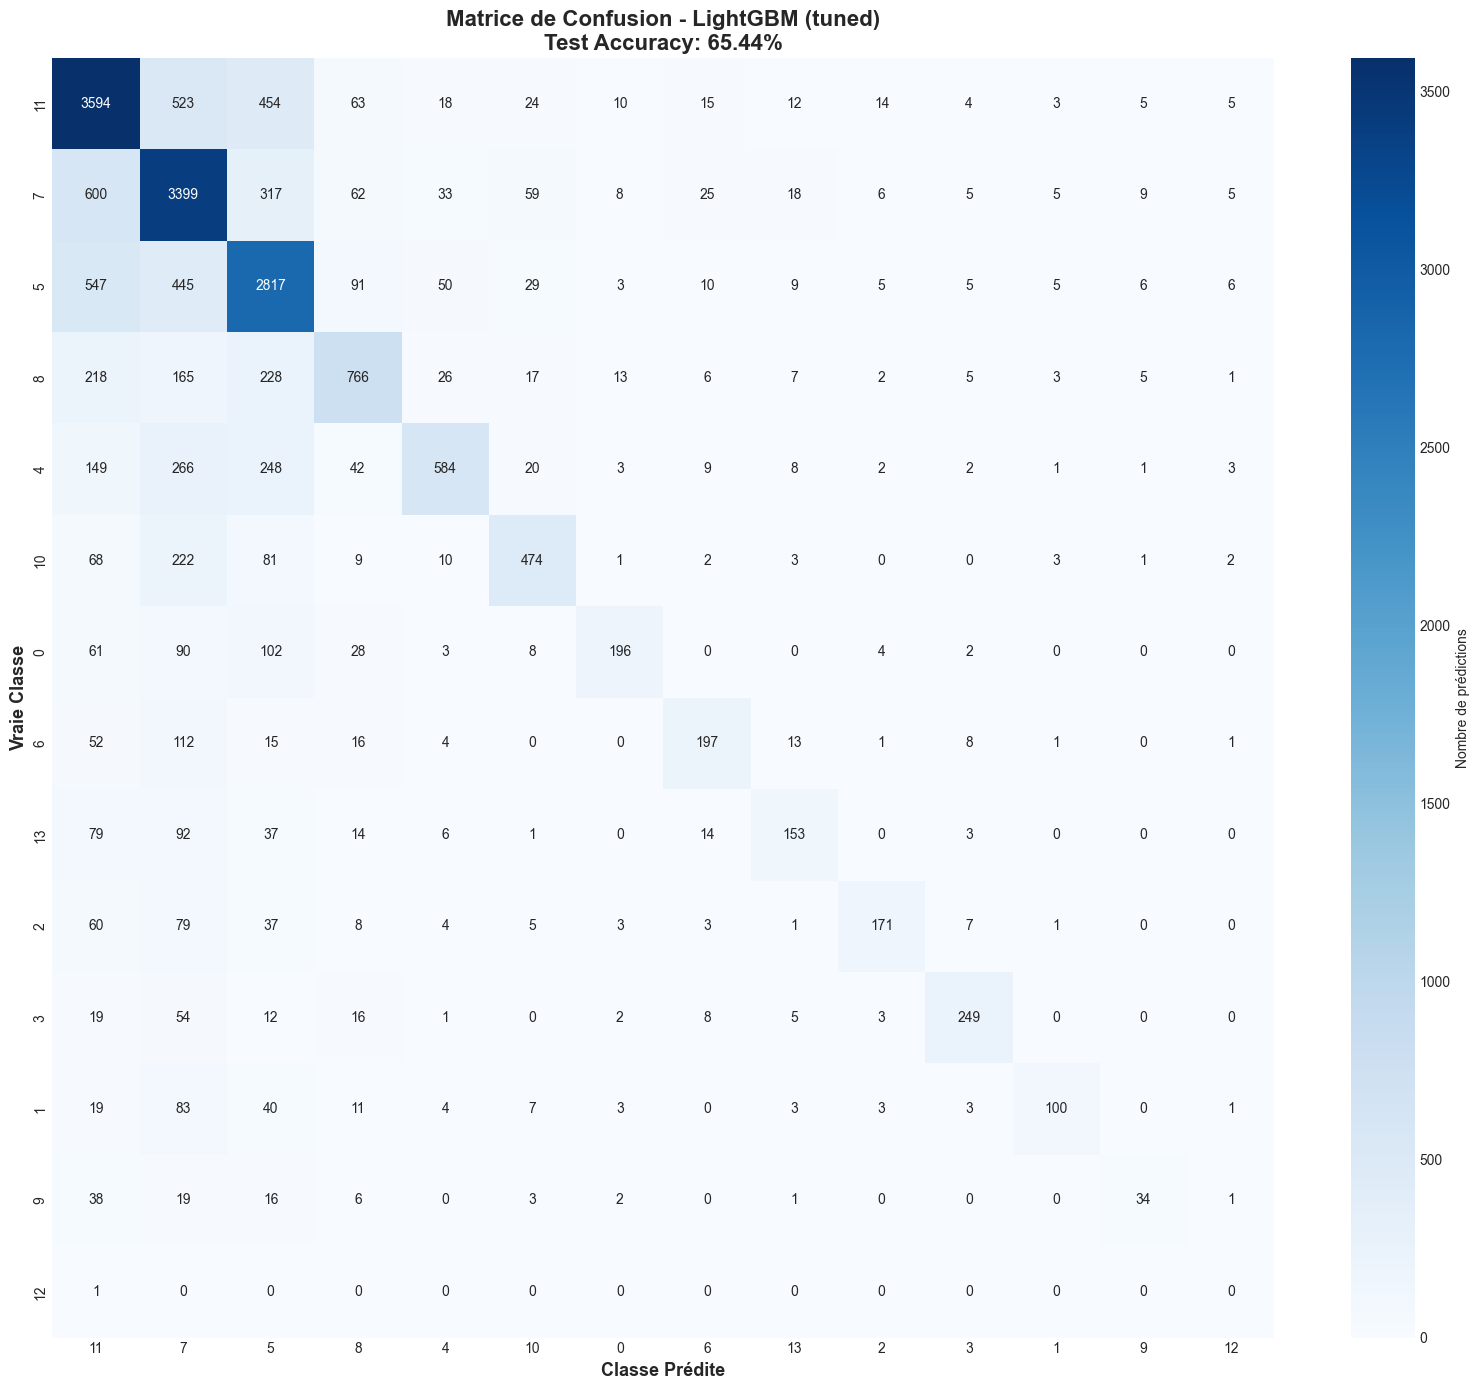


FIN DU TEST FINAL AVEC LIGHTGBM TUNÉ


In [ ]:

# 9. ÉVALUATION FINALE SUR LE TEST SET AVEC LIGHTGBM TUNÉ


print("ÉVALUATION FINALE - LIGHTGBM (TUNED)")

# Récupérer les meilleurs paramètres depuis tuning_df
lgbm_row = tuning_df[tuning_df['Model'] == "LightGBM  (tuned)"].iloc[0]
best_params = lgbm_row['Best Params']

print("\n Paramètres LightGBM optimisés :")
for k, v in best_params.items():
    print(f"   {k}: {v}")

#  Créer un modèle LightGBM final avec les paramètres optimisés
best_model = LGBMClassifier(
    **best_params,
    random_state=42,
    n_jobs=2,
    verbose=-1,
    force_col_wise=True
)


X_train_final = X_trainval.values
X_test_final = X_test.values

#  Réentraîner le modèle sur tout train+val
print("\n Réentraînement du LightGBM (tuned) sur train+val...")
best_model.fit(X_train_final, y_trainval)

#  Prédiction sur le test set
y_pred_test = best_model.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_pred_test) * 100

print("PERFORMANCE SUR LE TEST SET  - LIGHTGBM (TUNED)")

print(f"\n Test Accuracy: {test_accuracy:.2f}%")
print(f" Validation Accuracy du tuning: {lgbm_row['Val Accuracy (%)']:.2f}%")
print(f" Différence: {test_accuracy - lgbm_row['Val Accuracy (%)']:.2f}%")

#  Rapport de classification (top 10 classes)
print("\n" + "-"*80)
print("CLASSIFICATION REPORT (Top 10 classes):")
print("-"*80)

top_10_classes = pd.Series(y_test).value_counts().head(10).index.tolist()
mask = pd.Series(y_test).isin(top_10_classes)

print(classification_report(
    y_test[mask],
    pd.Series(y_pred_test)[mask].values,
    labels=top_10_classes,
    zero_division=0
))

#  Matrice de confusion (top 20 classes)
print("\n Génération de la matrice de confusion (top 20 classes)...")
top_20_classes = pd.Series(y_test).value_counts().head(20).index.tolist()
mask = pd.Series(y_test).isin(top_20_classes)

cm = confusion_matrix(
    y_test[mask], 
    pd.Series(y_pred_test)[mask].values, 
    labels=top_20_classes
)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_20_classes, yticklabels=top_20_classes,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion - LightGBM (tuned)\nTest Accuracy: {test_accuracy:.2f}%',
          fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=13, fontweight='bold')
plt.xlabel('Classe Prédite', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_lgbm_tuned.png', dpi=300, bbox_inches='tight')
print("✓ Matrice de confusion sauvegardée: confusion_matrix_lgbm_tuned.png")
plt.show()

print("\n" + "="*80)
print("FIN DU TEST FINAL AVEC LIGHTGBM TUNÉ")



 Génération de la matrice de confusion (top 20 classes)...
✓ Matrice de confusion sauvegardée: confusion_matrix_lgbm_tuned.png


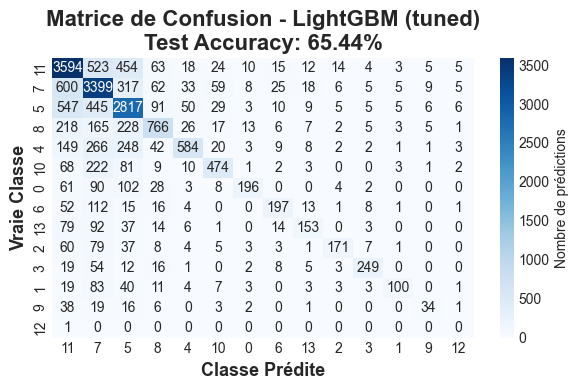

In [26]:
print("\n Génération de la matrice de confusion (top 20 classes)...")
top_20_classes = pd.Series(y_test).value_counts().head(20).index.tolist()
mask = pd.Series(y_test).isin(top_20_classes)

cm = confusion_matrix(
    y_test[mask], 
    pd.Series(y_pred_test)[mask].values, 
    labels=top_20_classes
)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_20_classes, yticklabels=top_20_classes,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion - LightGBM (tuned)\nTest Accuracy: {test_accuracy:.2f}%',
          fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=13, fontweight='bold')
plt.xlabel('Classe Prédite', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_lgbm_tuned.png', dpi=300, bbox_inches='tight')
print("✓ Matrice de confusion sauvegardée: confusion_matrix_lgbm_tuned.png")
plt.show()


 Génération de la matrice de confusion normalisée (top 20 classes)...


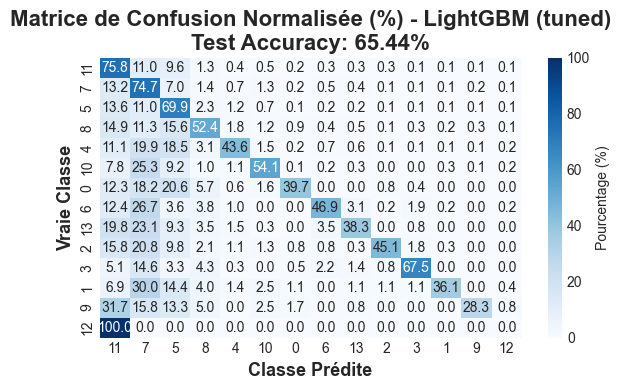

In [34]:
print("\n Génération de la matrice de confusion normalisée (top 20 classes)...")

top_20_classes = pd.Series(y_test).value_counts().head(20).index.tolist()
mask = pd.Series(y_test).isin(top_20_classes)

# Matrice de confusion brute
cm = confusion_matrix(
    y_test[mask],
    pd.Series(y_pred_test)[mask].values,
    labels=top_20_classes
)

# Normalisation par ligne (pourcentage)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=top_20_classes, yticklabels=top_20_classes,
            cbar_kws={'label': 'Pourcentage (%)'})
plt.title(f'Matrice de Confusion Normalisée (%) - LightGBM (tuned)\nTest Accuracy: {test_accuracy:.2f}%',
          fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=13, fontweight='bold')
plt.xlabel('Classe Prédite', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
